# Fraud Detection For Online Purchases

> This exercise uses simulated transaction data to find potential fraud purchases.

> Author: Menghan Xu

> Date: 2016-10-01

### Importing and Displaying Data

In [233]:
import pandas as pd
import numpy as np
import pylab as plt
from IPython.display import display

%matplotlib inline

transactions = pd.read_csv("Fraud_Data.csv")
ip_country_xw = pd.read_csv("IpAddress_to_Country.csv")

# convert timestamp string to pd.timestamp
transactions.signup_time = transactions.signup_time.apply(pd.Timestamp)
transactions.purchase_time = transactions.purchase_time.apply(pd.Timestamp)

# rename class to fraud because class is a reserved word
transactions.rename(columns={'class':'fraud'}, inplace=True)
# sort crosswalk by lower ip bound
ip_country_xw.sort_values(by='lower_bound_ip_address', inplace=True)

In [234]:
display(transactions.head(1))
print "Transaction dataset has {} samples with {} features each.".format(*transactions.shape)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0


Transaction dataset has 151112 samples with 11 features each.


In [235]:
display(ip_country_xw.head(1))
print "IP address to country dataset has {} samples with {} features each.".format(*ip_country_xw.shape)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia


IP address to country dataset has 138846 samples with 3 features each.


### Performing initial checks

In [236]:
# confirm there are no null values in either datasets
print transactions.isnull().values.any()
print ip_country_xw.isnull().values.any()

False
False


In [237]:
# check for uniqueness of user_id, device_id, and ip_address
# found that user_id is unique, the other two are not
for var in ['user_id','device_id','ip_address']:
    g = transactions.groupby(by=var)[var]
    print "Frequency of number of transactions per", var
    print g.count().value_counts(sort=False, normalize=True)[0:5]
    print

Frequency of number of transactions per user_id
1    1.0
Name: user_id, dtype: float64

Frequency of number of transactions per device_id
1    0.955239
2    0.038614
3    0.000652
4    0.000029
5    0.000094
Name: device_id, dtype: float64

Frequency of number of transactions per ip_address
1    0.994704
2    0.000007
3    0.000014
4    0.000028
5    0.000091
Name: ip_address, dtype: float64



In [238]:
# check min and max of continuous vars to see if they make sense
for var in ['signup_time','purchase_time','purchase_value', 'age']:
    print "Range of", var, "is", transactions[var].min(), transactions[var].max()

Range of signup_time is 2015-01-01 00:00:42 2015-08-18 04:40:29
Range of purchase_time is 2015-01-01 00:00:44 2015-12-16 02:56:05
Range of purchase_value is 9 154
Range of age is 18 76


In [239]:
# confirm there is no overlap in ip address
nextrow = ip_country_xw.shift(-1)
print (ip_country_xw.upper_bound_ip_address >= nextrow.lower_bound_ip_address).any()

False


### Assign each transaction a country based on ip address

In [240]:
# assign each transaction an index based on lower ip bound
start_idx = np.searchsorted(ip_country_xw['lower_bound_ip_address'], transactions['ip_address'], side='right')-1
# assign each transaction an index based on upper ip bound
end_idx = np.searchsorted(ip_country_xw['upper_bound_ip_address'], transactions['ip_address'])

# if the two indices agree, assign that number; otherwise assign -1 as none
transactions['idx'] = [x if x==y else -1 for x, y in zip(start_idx, end_idx)]

# merge the data based on index
ip_country_xw['idx'] = ip_country_xw.index
full_data = transactions.merge(ip_country_xw, how='left', on='idx').drop(['lower_bound_ip_address', 'upper_bound_ip_address','idx'],axis=1)

full_data['country'] = full_data['country'].apply(lambda x: 'NA' if pd.isnull(x) else x)

In [241]:
full_data.country.value_counts(normalize=True)[0:5]

United States     0.384146
NA                0.145362
China             0.079663
Japan             0.048348
United Kingdom    0.029713
Name: country, dtype: float64

### Create additional variables

In [242]:
# add time-related info
full_data['lapsed_time'] = full_data['purchase_time'] - full_data['signup_time']
full_data['lapsed_secs'] = full_data['lapsed_time'].map(lambda x: x.seconds)

full_data['signup_mon'] = full_data['signup_time'].map(lambda x: x.month)
full_data['purchase_mon'] = full_data['purchase_time'].map(lambda x: x.month)
full_data['signup_weekday'] = full_data['signup_time'].map(lambda x: x.weekday())
full_data['purchase_weekday'] = full_data['purchase_time'].map(lambda x: x.weekday())

# add unique counts
full_data['device_counts'] = full_data.groupby('device_id')['device_id'].transform('count')
full_data['ip_counts'] = full_data.groupby('ip_address')['ip_address'].transform('count')

In [243]:
display(full_data.head(1))

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,fraud,country,lapsed_time,lapsed_secs,signup_mon,purchase_mon,signup_weekday,purchase_weekday,device_counts,ip_counts
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,13882,2,4,1,5,1,1


### Initial investigation of the importance of each feature

In [244]:
# check the overall fraud percentage
full_data.fraud.mean()

0.093645772671925462

In [245]:
# A table that is broken down by examvar and shows the sum and rate of the target var
def freq_table(data, examvar, target):
    g = data.groupby(examvar)[target]
    return pd.concat([g.count().rename('total'), g.sum(), g.mean().rename('rate')], axis=1)

In [246]:
from scipy.stats import chi2_contingency

# display the frequency table for each discrete variable, calculate chi2 statistics
def examine_discrete_vars (data, target, examvars):
         
    for idx, var in enumerate(examvars):
        
        print freq_table(data, var, target)
        p = chi2_contingency(pd.crosstab(full_data[var], full_data[target]))[1]
        print "P-val of chi2 test on", var, "is", p, "\n"

examine_discrete_vars (full_data, 'fraud', ['source','browser','sex','signup_mon','purchase_mon'])

        total  fraud      rate
source                        
Ads     59881   5513  0.092066
Direct  30616   3226  0.105370
SEO     60615   5412  0.089285
P-val of chi2 test on source is 7.98199083644e-15 

         total  fraud      rate
browser                        
Chrome   61432   6069  0.098792
FireFox  24610   2342  0.095165
IE       36727   3187  0.086775
Opera     3676    328  0.089227
Safari   24667   2225  0.090201
P-val of chi2 test on browser is 4.91602835036e-09 

     total  fraud      rate
sex                        
F    62819   5717  0.091007
M    88293   8434  0.095523
P-val of chi2 test on sex is 0.00307265426324 

            total  fraud      rate
signup_mon                        
1           26978   8494  0.314849
2           17535    818  0.046650
3           19555    879  0.044950
4           18895    872  0.046150
5           19338    844  0.043645
6           18633    859  0.046101
7           19454    897  0.046109
8           10724    488  0.045505
P-val 

LEGEND: red means fraud is true, green means fraud is false.


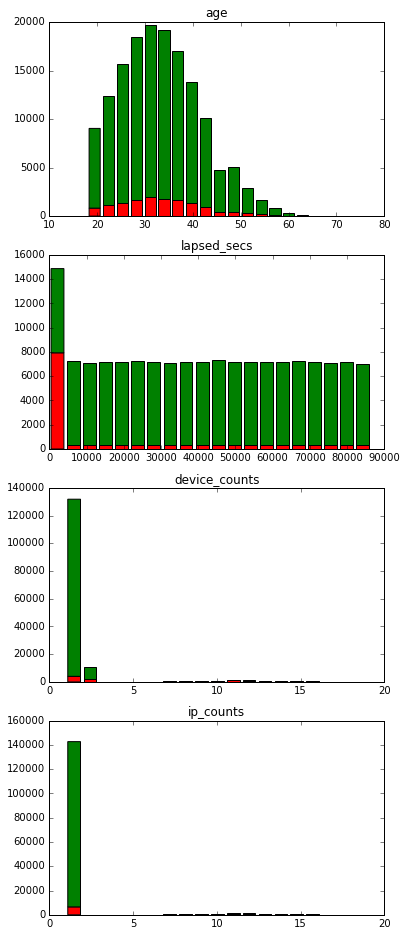

In [247]:
# create a stacked histogram of each continuous variable
def examine_cont_vars (data, target, examvars):
    target0 = data.loc[data[target]==0]
    target1 = data.loc[data[target]==1]
    
    fig, ax = plt.subplots(len(examvars),1, figsize=(6,4*len(examvars)))    
    print 'LEGEND: red means', target, 'is true, green means', target, 'is false.'
    
    for idx, var in enumerate(examvars):
        
        ax[idx].hist([target1[var], target0[var]], bins=20, stacked=True, color=['r','g'])
        ax[idx].set_title(var)

examine_cont_vars (full_data, 'fraud', ['age','lapsed_secs','device_counts','ip_counts'])

## Fraud percent is very high when lapsed time is small. Examine further


In [248]:
freq_table(full_data, 'lapsed_secs', 'fraud').head()

,total,fraud,rate
lapsed_secs,,,
1,7602,7600,0.999737
2,3,0,0.000000
3,1,0,0.000000
4,3,1,0.333333
6,1,0,0.000000


### When the purchase is done within the second of signup, 99.9% of time it is fraud!

> It's not surprising if the fraud is done electronically. This may represent one type of fraud.

> The 2 nonfraud transactions may be labeled wrongly. Notify company.

> Re-examine the data eliminating those observations

0    136959
1      6551
Name: fraud, dtype: int64
        total  fraud      rate
source                        
Ads     56874   2506  0.044062
Direct  28959   1570  0.054215
SEO     57677   2475  0.042911
P-val of chi2 test on source is 7.98199083644e-15 

         total  fraud      rate
browser                        
Chrome   58002   2639  0.045498
FireFox  23330   1063  0.045564
IE       35135   1595  0.045396
Opera     3507    160  0.045623
Safari   23536   1094  0.046482
P-val of chi2 test on browser is 4.91602835036e-09 

     total  fraud      rate
sex                        
F    59805   2703  0.045197
M    83705   3848  0.045971
P-val of chi2 test on sex is 0.00307265426324 

            total  fraud      rate
signup_mon                        
1           19378    894  0.046135
2           17535    818  0.046650
3           19553    879  0.044955
4           18895    872  0.046150
5           19338    844  0.043645
6           18633    859  0.046101
7           19454    897  

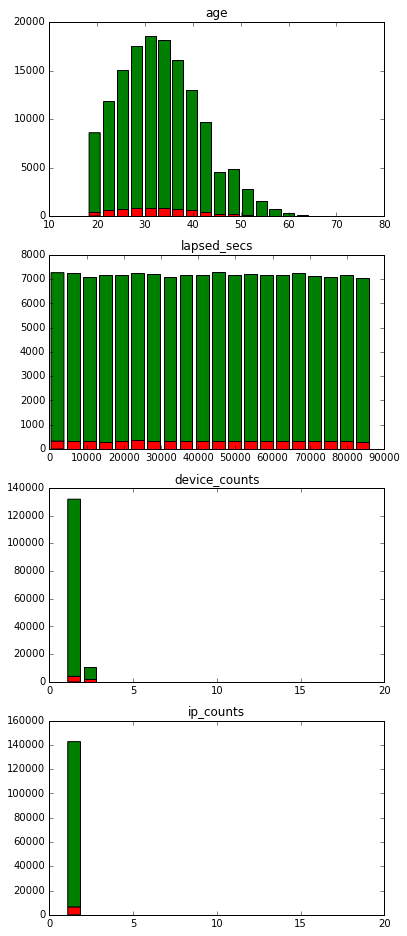

In [249]:
# make a reduced dataset that contains only transactions > 1 sec
red_data = full_data.loc[full_data.lapsed_secs>1]
print red_data['fraud'].value_counts()
examine_discrete_vars (red_data, 'fraud', ['source','browser','sex','signup_mon','purchase_mon'])
examine_cont_vars (red_data, 'fraud', ['age','lapsed_secs','device_counts','ip_counts'])

In [250]:
X = red_data[['purchase_value','source','sex','age','lapsed_secs','device_counts','ip_counts','country']]

# make dummy variables for only the top countries to avoid overfitting
top_countries = X['country'].value_counts()[0:4]
C = X.country.apply(lambda x: x if x in top_countries else 'other')
X.loc[:,'top_country'] = C

X = pd.get_dummies(X.drop('country', axis=1))
y = np.ravel(red_data[['fraud']])
X.head(1)

,purchase_value,age,lapsed_secs,device_counts,ip_counts,source_Ads,source_Direct,source_SEO,sex_F,sex_M,top_country_China,top_country_Japan,top_country_NA,top_country_United States,top_country_other
0,34,39,13882,1,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Fitting a random forest model because 
> 1. Does not need much pre-processing like feature scaling or adding interaction terms

> 2. Runs fast compared to other models such as SVM

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

clf = RandomForestClassifier()
# chose the auc score because it deals well with imbalanced classes
auc_scorer = make_scorer(roc_auc_score)
stratifiedCV = StratifiedShuffleSplit(n_splits=3, random_state=0)

params = {'max_features':[8,9,10], 'min_samples_split':[2,3,4], 'max_depth':[3,4,5]}
# params = {'max_features':[9], 'min_samples_split':[3], 'max_depth':[4]}  # test params

starttime=time.time()
grid_search = GridSearchCV(estimator=clf, param_grid=params, scoring=auc_scorer, cv = stratifiedCV)
grid_search.fit(X_train, y_train)
print "GridSearchCV took {:.2f} seconds.".format(time.time()-starttime)

print(grid_search.best_params_)
clf = grid_search.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training auc score of {:.4f}.".format(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
print "Tuned model has a testing auc score of {:.4f}.".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

print confusion_matrix(y_train, clf.predict(X_train))
print confusion_matrix(y_test, clf.predict(X_test))

GridSearchCV took 52.90 seconds.
{'max_features': 8, 'min_samples_split': 2, 'max_depth': 3}
Tuned model has a training auc score of 0.6752.
Tuned model has a testing auc score of 0.6596.
[[102719      0]
 [  4913      0]]
[[34240     0]
 [ 1638     0]]


### The zeros for the predicted "y"s in the confusion matrix are expected, since our class is imbalanced and there is no strong predictor. But it's not an issue because we care more about the "probability" instead of a binary classification.

In [252]:
# Print the feature ranking
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. device_counts (0.920243)
2. source_Direct (0.050689)
3. ip_counts (0.009929)
4. lapsed_secs (0.005288)
5. age (0.004974)
6. purchase_value (0.004811)
7. source_SEO (0.003023)
8. source_Ads (0.000591)
9. sex_F (0.000178)
10. sex_M (0.000152)
11. top_country_NA (0.000070)
12. top_country_Japan (0.000052)
13. top_country_other (0.000000)
14. top_country_United States (0.000000)
15. top_country_China (0.000000)


     p_thres       fpr       tpr      slope
0   1.295431  0.000000  0.000000        NaN
1   0.295431  0.000321  0.003053   9.501610
2   0.291165  0.000321  0.003663  11.401931
3   0.271254  0.000467  0.004274   9.145299
4   0.270652  0.010076  0.105006  10.421475
5   0.267035  0.010193  0.105617  10.361927
6   0.266387  0.010426  0.110501  10.598154
7   0.243083  0.010456  0.110501  10.568550
8   0.223643  0.010572  0.111111  10.509515
9   0.221360  0.010631  0.111111  10.451770
10  0.199128  0.035047  0.236264   6.741392
11  0.198863  0.035076  0.236264   6.735779
12  0.196845  0.035894  0.242979   6.769414
13  0.193421  0.035923  0.242979   6.763910
14  0.193401  0.036127  0.242979   6.725634
15  0.187321  0.036624  0.245421   6.701135
16  0.170264  0.036828  0.245421   6.663936
17  0.168906  0.037500  0.246032   6.560847
18  0.168886  0.062062  0.384615   6.197285
19  0.166603  0.062237  0.384615   6.179836
20  0.165289  0.062266  0.384615   6.176938
21  0.165269  0.062266  0.385836

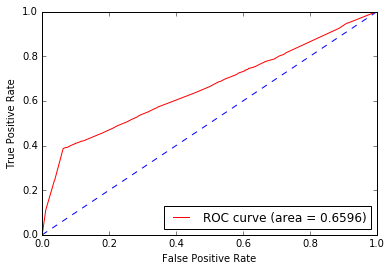

In [254]:
from sklearn.metrics import roc_curve, auc

preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, thres = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='b', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auc_table = pd.DataFrame(np.transpose([thres, fpr, tpr]), columns=['p_thres','fpr','tpr'])
auc_table['slope'] = auc_table.tpr/auc_table.fpr
print auc_table.loc[auc_table.fpr<=0.1]

# Conclusion:

### From earlier analysis and common sense, I would mark all transactions that are made within the second of signing up as fraud. In addition to declining the transaction, I would also advice the company to mark their user accounts for "special attention".

### As of the rest of the transactions, I would run them through the random forest classifier, and classify the transactions that have a probability of fraud greater than 0.2 as "potential fraud". Instead of declining the purchase, I would create some friction for the user, possibilily asking for email verification and so on.

